**1)** A megismert 100 kutya/macska adatbázison futtasd le az alábbi kísérletet.
*    szürkeárnyalatos képeken
*    64 x 64-re átméretezve
*    train/test 80-20% vágás
*    sztochasztikus gradient descent tanulóval
*    jellemzőkészlet: pixelek

Kérdés, hogy mennyire függ az elért pontosság a train test split véletlenszerűségétől! Ehhez százszor futtasd le, hogy
a 100 képből véletlenszerűen választasz 80 train és 20 test esetet tanítasz a trainen, accuracyt mérsz a teszten.


In [ ]:
# képadatbázis letöltése

import os
import urllib.request
import zipfile
 
url = 'https://github.com/rfarkas/student_data/raw/main/images/100imgs.zip'
urllib.request.urlretrieve(url,'t.zip') 
zipfile.ZipFile('t.zip').extractall('tmp_imgs')

In [ ]:
# jellemzőkinyerés

import cv2 as cv #OpenCV

features = []
labels = []

for f in os.listdir('tmp_imgs'): 
  image = cv.imread('tmp_imgs/'+f) 
  label = f.split(os.path.sep)[-1].split(".")[0] 
  small_image = cv.resize(image,(64,64))
  small_gray_image = cv.cvtColor(small_image,cv.COLOR_BGR2GRAY)
  pixel = small_gray_image.flatten()
  labels.append(label)
  features.append(pixel)

In [ ]:
# gépi tanulási kísérlet

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

accuracy = []
cl = SGDClassifier()
for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2) # véletlenszerű train/test szétvágása a 100 képnek
  model = cl.fit(X_train, y_train) # tanítás train halmazon
  accuracy.append(model.score(X_test, y_test)) # kiértékelés a test halmazon

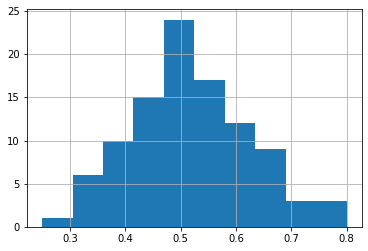

In [ ]:
# eredmények vizualizációja

import pandas as pd
pd.Series(accuracy).hist()

Ilyen kicsi adatbázison, az eredmények nagyban függenek a train/test vágástól!!! Célszerű legalább párezres adatbázison kiértékelni, hogy robosztusabbak legyenek az eredmények.

**2)** Milyen pontossággal tudjuk egy arcképről azonosítani az érzelmeket?

Hajts végre egy tanító-kiértékelő adatbázis bontással predikciós kísérletet az alábbi adatbázison!

In [ ]:
import pandas as pd
data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/images/fer2013_1K.csv')

In [ ]:
data

In [ ]:
print(data.columns)
len(data)

In [ ]:
#48x48 szürke képek egy stringbe vannak kódolva. A 11. kép kiolvasása:
import numpy as np
image = np.reshape(np.asarray(data.pixels[11].split(' '), np.uint8), (48,48))
plt.imshow(image, cmap="gray")

In [ ]:
def str2img(img):
  return np.reshape(np.asarray(img.split(' '), np.uint8), (48,48))

In [ ]:
!wget https://raw.githubusercontent.com/christiansafka/img2vec/master/img2vec_pytorch/img_to_vec.py

In [ ]:
from img_to_vec import Img2Vec
img2vec = Img2Vec()

In [ ]:
from PIL import Image 
img2vec.get_vec(Image.fromarray(image).convert('RGB')) # img2vec csak RGB képeket tud kezelni, a szürkeárnyalatos képeinket RGB-be kell konvertálni!

In [ ]:
imgvecs = []
for i in data.pixels:
  imgvec = img2vec.get_vec(Image.fromarray(str2img(i)).convert('RGB'))
  imgvecs.append(imgvec)

In [ ]:
# train/test vágás
from sklearn.model_selection import train_test_split
labels = data.emotion.tolist()
train_features, test_features, train_labels, test_label = train_test_split(imgvecs,labels, test_size=0.2)

In [ ]:
# KNN osztályozó tanítása
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_features, train_labels)

In [ ]:
# Kiértékelés a teszt halmazon
from sklearn.metrics import classification_report

In [ ]:
pred = model.predict(test_features)
print(classification_report(y_pred=pred, y_true=test_label))

In [ ]:
# az eredményeket mindig hasonlítsuk egy egyszerű döntési szabály eredményeihez!
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent',random_state=0)
dummy.fit(train_features, train_labels)

In [ ]:
pred_dummy = dummy.predict(test_features)
print(classification_report(y_pred=pred_dummy, y_true=test_label))